# PoC RNN Polymer
Matt Hagy (<matthew.hagy@gmail.com>), Februrary 16th, 2019

Very preliminary proof-of-concept (PoC) work in analyzing a
[recurrent neural network](https://en.wikipedia.org/wiki/Recurrent_neural_network)
(RNN) using basic [polymer theory](https://en.wikipedia.org/wiki/Polymer_physics).
I myself am a novice with RNN theory and I've forgotten most of the polymer theory I used to know and, therefore, I believe there is significant potential to further advance this naive PoC work.

This PoC builds off the excellent example of using RNNs for interpreting dates in varied human formats by Zafarali Ahmed in [keras-attention](https://github.com/datalogue/keras-attention). E.g., converting “November 5, 2016” to “2016–11–05”. I’m simply studying the structure of the RNN states using an RNN developed in that work.

I focus on the 512 encoder units within the
[LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) layer of this RNN.
I treat each encoder as a linear polymer chain growing in 1-dimension. I explore the dynamics of each encoder unit for different input strings. The autocorrelation function for each encoder unit is computed to quantify the encoders dynamics for each example input string.

The main result is that most encoders show boring dynamics, but a few show interesting dynamics with similar, but varied autocorrelation function shape. I attempt to explain these dynamics using concepts I vaguely remember from nonequilibrium statistical mechanics of polymers. (I’m a little ashamed to have forgotten so much from my undergrad and grad study in these specific areas.) See the Discussion section at the end of the notebook for more details.

Some references I used in developing this work.
* [How to Visualize Your Recurrent Neural Network with Attention in Keras](https://medium.com/datalogue/attention-in-keras-1892773a4f22) (seed work)
* [Visualizing and Understanding Recurrent Networks](https://arxiv.org/abs/1506.02078)
* [Visualizing LSTM Networks. Part I](https://medium.com/asap-report/visualizing-lstm-networks-part-i-f1d3fa6aace7)
* [Neural network applications in polymerization processes](http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-66322005000300009)
* [LSTM Visualization Example](https://github.com/asap-report/lstm-visualisation)
* [Tutorial: LSTM Networks for Sentiment Analysis](http://deeplearning.net/tutorial/lstm.html)
* [Launch an AWS Deep Learning AMI](https://aws.amazon.com/getting-started/tutorials/get-started-dlami)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from IPython.display import SVG

from keras.utils.vis_utils import model_to_dot
from keras.models import Model

Using TensorFlow backend.


In [2]:
# include companion project keras-attention libraries
import sys
sys.path.append('../keras-attention')

from data.reader import Vocabulary, Data
from models.NMT import simpleNMT

## Load trained model
Load trained model. Follow instructions in [keras-attention](https://github.com/datalogue/keras-attention) to get a trained model. I recommend using a GPU-equipped VM on AWS EC2.

In [3]:
padding = 50
input_vocab = Vocabulary('../keras-attention/data/human_vocab.json', padding=padding)
output_vocab = Vocabulary('../keras-attention/data/machine_vocab.json', padding=padding)

In [4]:
pred_model = simpleNMT(trainable=False,
                       pad_length=padding,
                       n_chars=input_vocab.size(),
                       n_labels=output_vocab.size())

inputs shape: (?, ?, 512)


In [5]:
# load the weights from training
pred_model.load_weights('../keras-attention/weights/NMT.50-0.01.hdf5', by_name=True)

## Model structure
Show the high-level layers used to build this RNN

In [6]:
def visualize_model(model):
    return SVG(model_to_dot(model).create(prog='dot', format='svg'))

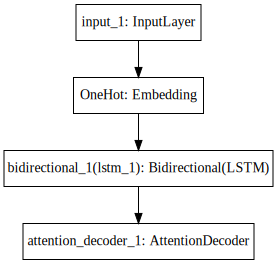

In [7]:
visualize_model(pred_model)

## Example
Example of applying the model on an example input strings. Shows just how "magical" and cool ML can be when well applied.

In [8]:
def encode(input_string):
    "Convert an input string in an array of numbers, on which modeling can be applied"
    return np.array([input_vocab.string_to_int(input_string)])

def apply_model(input_string):
    "Run the model on a single input string"
    full_prediction = pred_model.predict(encode(input_string))
    prediction = np.argmax(full_prediction[0], axis=-1)
    return output_vocab.int_to_string(prediction)
    
def show_example_ml_application(input_string):
    "Interpret the terminal and padding characters in raw results"
    results = apply_model(input_string)
    pretty = ''.join('|' if x=='<eot>' else ('' if x == '<unk>' else x)
                     for x in results)
    print(repr(input_string), '->', pretty)
    

examples = [
    'February 16th, 2019',
    'March the 12th, 2012',
    'Jan 1 1990',
    '02-03-1998'
]

for example in examples:
    show_example_ml_application(example)

'February 16th, 2019' -> 2019-02-16|
'March the 12th, 2012' -> 2012-03-03|
'Jan 1 1990' -> 1990-01-01|
'02-03-1998' -> 1998-03-02|


## Analyze LSTM output sequence for example
Fetch the bidirectional LSTM layer and compute the LSTM output sequence for the example input.

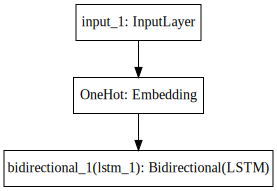

In [9]:
# Create a model that outputs the intermediate output of the bidirectional LSTM layer
intermediate_layer_model = Model(inputs=pred_model.input,
                                 outputs=pred_model.get_layer('bidirectional_1').output)
visualize_model(intermediate_layer_model)

In [10]:
# Use a single example string in the following initial exploration work.
# The model is applied one character at a time and therefore gives a sequence of states for
# each RNN encoder.
# Note all strings are padded to length `padding` when applying the model using `pad` characters.
explore_example = examples[0]
explore_example

'February 16th, 2019'

In [11]:
# Show what the output of aplying the model looks like
intermediate_output = intermediate_layer_model.predict(encode(explore_example))
intermediate_output.shape

(1, 50, 512)

Text(0.5,0,'Encoder Index')

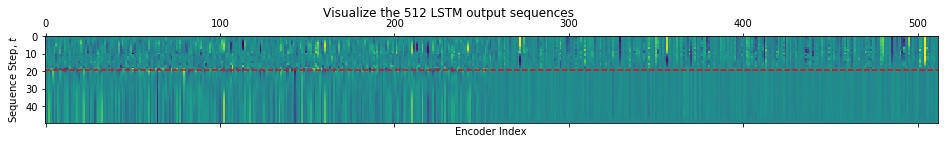

In [12]:
# Roughly visualize all encoders and highlight the sequence length to show when the 
# string is converted to padding characters.
plt.matshow(intermediate_output[0])
plt.suptitle(f'Visualize the {intermediate_output.shape[2]} LSTM output sequences')
plt.axhline(len(explore_example), color='r', linestyle='--')
plt.ylabel('Sequence Step, $t$')
plt.xlabel('Encoder Index')

In [13]:
# Sample random encoders to show examples. Use same random seed so this is repeatable.
random_encoder_indices = np.arange(intermediate_output.shape[2])
np.random.RandomState(0xCAFE).shuffle(random_encoder_indices)
random_encoder_indices = random_encoder_indices[:5]
random_encoder_indices

array([405, 496, 432,  47, 121])

In [14]:
def example_plot_helper(data_func, ylabel, title, ylim):
    "Helper to create similar plots for encoder dynamics"
    plt.figure(figsize=(7,4.5))
    for index in random_encoder_indices:
        plt.plot(data_func(index), marker='.', label=str(index))
    plt.axvline(len(explore_example), color='k', linestyle='--', label='string length')
    plt.xlabel('Sequence Step, $t$')
    plt.ylabel(ylabel)
    plt.title(title +  f'\nfor {repr(explore_example)} input')
    plt.ylim(*ylim)
    plt.legend(loc='upper right', title='Encoder Unit', ncol=3)

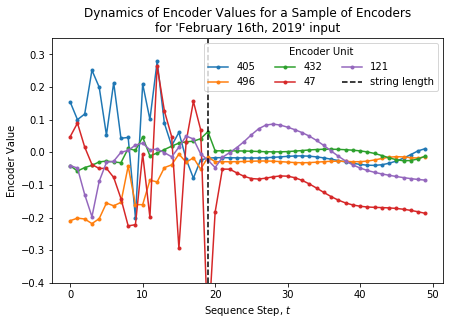

In [15]:
# Plot encoder unit dynamics for a sample of units
example_plot_helper(
    data_func=lambda index: intermediate_output[0, ::, index],
    ylabel='Encoder Value',
    title='Dynamics of Encoder Values for a Sample of Encoders',
    ylim=(-0.4, 0.35)
)

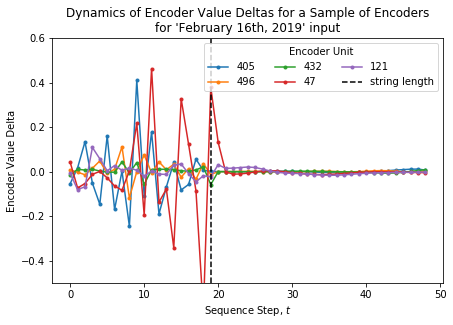

In [16]:
# Plot the deltas of dynamics
def dynamics_data_func(index):
    x = intermediate_output[0, ::, index]
    return x[1::] - x[:-1:]

example_plot_helper(
    data_func=dynamics_data_func,
    ylabel='Encoder Value Delta',
    title='Dynamics of Encoder Value Deltas for a Sample of Encoders',
    ylim=(-0.5, 0.6)
)

## Compute sequences for a sample of random input strings

In [17]:
# Load example validation inputs
validation = Data('../keras-attention/data/validation.csv', input_vocab, output_vocab)
validation.load()
print(len(validation.inputs))
validation.inputs[:10]

1000


['25 set, 2002',
 '27, Jan 2017',
 '4 Me, 2000',
 'مارس 29 2007',
 '6 أغسطس 1983',
 '25 Mar 2007',
 '29 1月, 2019',
 '15/11/13',
 'Monday, 29 August 1983',
 '26 11月, 2007']

,count,mean,std,min,50%,75%,90%,95%,99%,max
0,1000.0,13.6,5.2,6.0,12.0,15.0,21.0,24.0,32.0,41.0


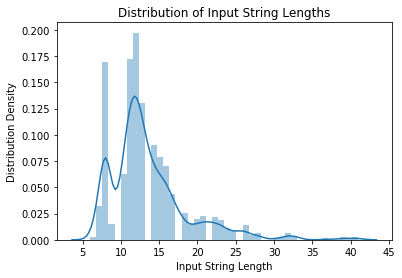

In [18]:
# Analyze the distribution of string lengths

string_lengths = pd.Series([len(x) for x in validation.inputs])
sns.distplot(string_lengths)
plt.title('Distribution of Input String Lengths')
plt.xlabel('Input String Length')
plt.ylabel('Distribution Density')

(string_lengths
 .describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])
 .round(1)
 .to_frame()
 .T)

In [19]:
def compute_lstm_sequence_for_input(input_string):
    return intermediate_layer_model.predict(encode(input_string))[0]

lstm_sequences = [compute_lstm_sequence_for_input(x) for x in tqdm(validation.inputs)]

100%|██████████| 1000/1000 [00:59<00:00, 16.96it/s]


In [20]:
lstm_sequences = np.array(lstm_sequences)
lstm_sequences.shape

(1000, 50, 512)

In [21]:
# Compute the RMS delta for each encoder across the N example trajectories for the
# N different input strings
lstm_rms_delta = np.mean(
    np.sqrt((lstm_sequences[::, 1::, ::] - lstm_sequences[::, :-1:, ::]) ** 2),
    axis=0
)
lstm_rms_delta.shape

(49, 512)

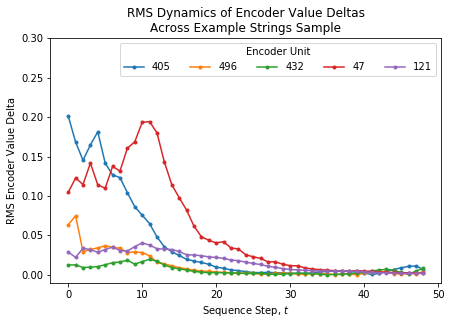

In [22]:
# Plot the RMS dynamics for a random sample of encoders
plt.figure(figsize=(7,4.5))
for index in random_encoder_indices:
    plt.plot(lstm_rms_delta[::, index], marker='.', label=str(index))
plt.xlabel('Sequence Step, $t$')
plt.ylabel('RMS Encoder Value Delta')
plt.title('RMS Dynamics of Encoder Value Deltas\nAcross Example Strings Sample')
plt.ylim(-0.01, 0.3)
plt.legend(loc='upper right', title='Encoder Unit', ncol=5)

## Distribution of Sum RMS Delta
For each encoder RMS dynamics, I sum the function to determine the extent to which the encoder has interesting dynamics.

In [23]:
# Compute sum dynamics (i.e., area under the curve) for each encoder
lstm_rms_delta_sum = pd.Series(lstm_rms_delta.sum(axis=0))
lstm_rms_delta_sum.sample(5, random_state=0xCAFE)

405    1.925775
496    0.581930
432    0.309807
47     2.833351
121    0.841751
dtype: float32

,count,mean,std,min,50%,75%,90%,95%,99%,max
0,512.0,1.3,0.8,0.2,1.1,1.8,2.5,2.8,3.7,5.4


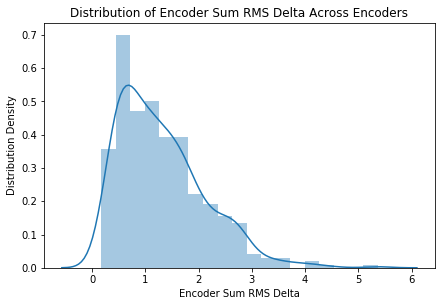

In [24]:
# Plot the distribution of encoder dynamics
plt.figure(figsize=(7,4.5))
sns.distplot(lstm_rms_delta_sum)
plt.title('Distribution of Encoder Sum RMS Delta Across Encoders')
plt.xlabel('Encoder Sum RMS Delta')
plt.ylabel('Distribution Density')

# Quantiles and other stats for the distribution of encoders
(lstm_rms_delta_sum
 .describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])
 .round(1)
 .to_frame()
 .T)

## Interpretation
From the distribution, we can see that most encoders have a small sum RMS delta. I interpret this to mean that most encoders don’t have particularly interesting dynamics. A small number of encoders appear to have richer dynamics and these will be investigated in the following analysis.


In [25]:
top_dynamics = lstm_rms_delta_sum.sort_values(ascending=False).head()
top_dynamics

309    5.361094
436    4.454443
346    4.100636
214    4.030795
50     4.005840
dtype: float32

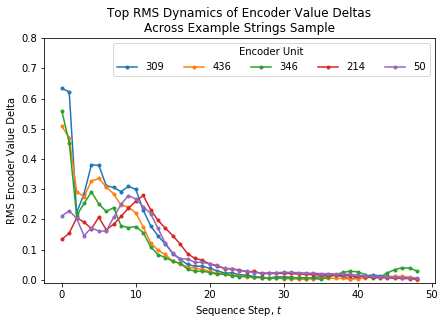

In [26]:
plt.figure(figsize=(7,4.5))
for index in top_dynamics.index:
    plt.plot(lstm_rms_delta[::, index], marker='.', label=str(index))
plt.xlabel('Sequence Step, $t$')
plt.ylabel('RMS Encoder Value Delta')
plt.title('Top RMS Dynamics of Encoder Value Deltas\nAcross Example Strings Sample')
plt.ylim(-0.01, 0.8)
plt.legend(loc='upper right', title='Encoder Unit', ncol=5)

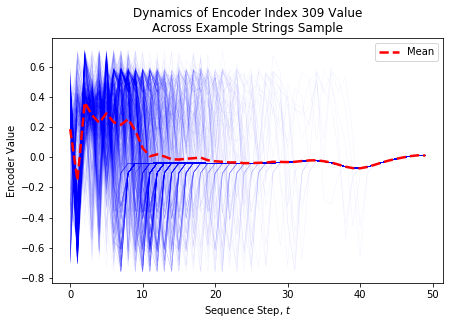

In [27]:
# Analyze the different trajectories for the most interesting encoder
interesting_index = 309
interesting_lstm_sequence = lstm_sequences[::, ::, interesting_index]

plt.figure(figsize=(7,4.5))
plt.plot(interesting_lstm_sequence.T, alpha=0.05, color='b', linewidth=0.5)
plt.plot(np.mean(interesting_lstm_sequence, axis=0), color='r', linestyle='--', 
         linewidth=2.5, label='Mean')
plt.xlabel('Sequence Step, $t$')
plt.ylabel('Encoder Value')
plt.title(f'Dynamics of Encoder Index {interesting_index} Value\nAcross Example Strings Sample')
#plt.ylim(-1.3, 1.5)
plt.legend(loc='upper right')
None

## Discussion
In this work, I’ve investigated the dynamics of LSTM encoder units on a sample of input strings by treating each encoder as a single linear polymer chain growing in one dimension. Encoders generally show rich and varied dynamics in the early stages; i.e., when consuming the beginning of an input sequence of characters. At later stages, the dynamics are found to stabilize towards a terminal value. This can be explained by most input strings having `<pad>` characters that fill out the end of each input sequence. We’d expect such `<pad>` characters to have a negligible impact on changing the value of each encoder after sufficient model training.

Interestingly, the majority of encoders have relatively low magnitude dynamics on average as quantified over a sample of input strings. A small number of encoders show larger magnitude dynamics and are visualized in the last figure of this work. There are some similarities in the shape of these correlation functions at short to intermediate time scales.

The "boring" dynamics at longer time scales is likely explained by the impact of `<pad>` characters on the dynamics of each encoder. Hence, we could think of each non-`<pad>` character as being a strong perturbation acting on the state of each encoder. In contrast, the `<pad>` characters can be thought of as weaker perturbations, although as shown in the example these perturbations still have some impact on the encoder dynamics.

One might imagine the ML model trying to minimize the impact of `<pad>` characters in deciding the output of character sequence on the final prediction, while still allowing the complex non-linear interactions in the LSTM layer. One might even say the `<pad>` perturbations look more like random noise in Brownian dynamics whereas the other perturbations are more like strong driving forces that vary with the characters in the input sequence.

Seeing as I know very little about RNNs and polymer dynamics, I’d imagine other people could do much more interesting things with these ideas. Further, I don’t know to what extent the results of this work are covered in existing prior work. It’s possible such RNN dynamics have already been quantified in a related fashion. 
